In [99]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from ModulationPy import PSKModem, QAMModem
from tqdm.notebook import tqdm, trange
from numpy import sqrt
plt.rcParams.update({'font.size': 15})

CHAN_NAME = 'link_chan_{}.mat'.format('2')




Number of user antennas:  4
Number of base station antennas:  64
Number of subcarriers:  256
Number of time moments:  100


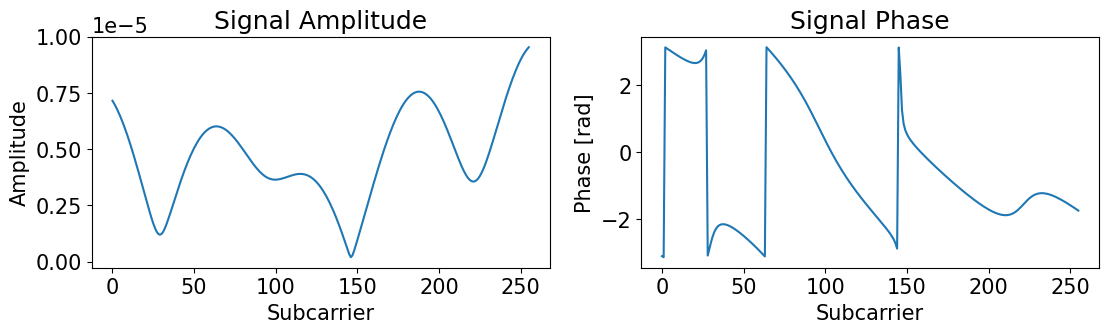

In [100]:
H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape

# Some info about signal
print('Number of user antennas: ', N_ue_ants )
print('Number of base station antennas: ', N_bs_ants)
print('Number of subcarriers: ', N_subcarriers)
print('Number of time moments: ', N_tti)

# Let's plot Amplitudes and Phases over frequencies for fixed pair of antennas
# and fixed time moment (TTI)
plt.figure(figsize = (13,3))
plt.subplot(1,2,1)
plt.plot(np.abs(H[0,0,:,0]))
plt.title('Signal Amplitude'); plt.xlabel('Subcarrier'); plt.ylabel('Amplitude')

plt.subplot(1,2,2)
plt.plot(np.angle(H[0,0,:,0]))
plt.title('Signal Phase'); plt.xlabel('Subcarrier'); plt.ylabel('Phase [rad]')
plt.show()

In [101]:
def bit_error_rate(received_bits, true_bits):
    '''Calculates bit error rate (BER) between two-bit sequences'''

    return np.mean(np.abs(received_bits - true_bits), axis = 1)


def get_noise(signal, SNR_dB):
    '''Returns complex AWGN tensor for a signal with the same shape
       satisfying SNR ratio
        Inputs:
            - signal: (np.ndarray) some signal array
            - SNR: (int) SNR value in decibels, which adjusts noise power.
                    if SNR is None, return 0 (no noise at all)
       '''
    if SNR_dB is None:
        return 0
    # complex-valued AWGN with 0 mean and unit variance with same size as @signal
    noise = np.sqrt(1/2) * (np.random.randn(*signal.shape) + 1j*np.random.randn(*signal.shape))

    # Calculate mean @signal power
    P_signal = np.mean(np.abs(signal)**2)

    # Normalize Noise to satisfy SNR
    noise_normed = noise * sqrt(10**(-SNR_dB/10) * P_signal)
    return noise_normed

In [102]:
def normalize(H):
    '''
    Normalizes the channel along UE antennas and subcarriers to have unit power on each receive antenna.
    '''
    # Shape of H
    N_ue, N_bs, N_f, N_tti = H.shape

    # Calculate norms along 0,2 axis (N_ue, N_f)
    norma = np.linalg.norm(H, ord = 'fro', axis = (0,2), keepdims = True)

    # return normalized channel
    H_normed = H / norma * sqrt(N_ue)
    return H_normed

In [103]:
bits = np.random.binomial(n = 1, p = 0.5, size = N_subcarriers)
print(bits)

[0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1
 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1
 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1
 0 1 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0
 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0
 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1]


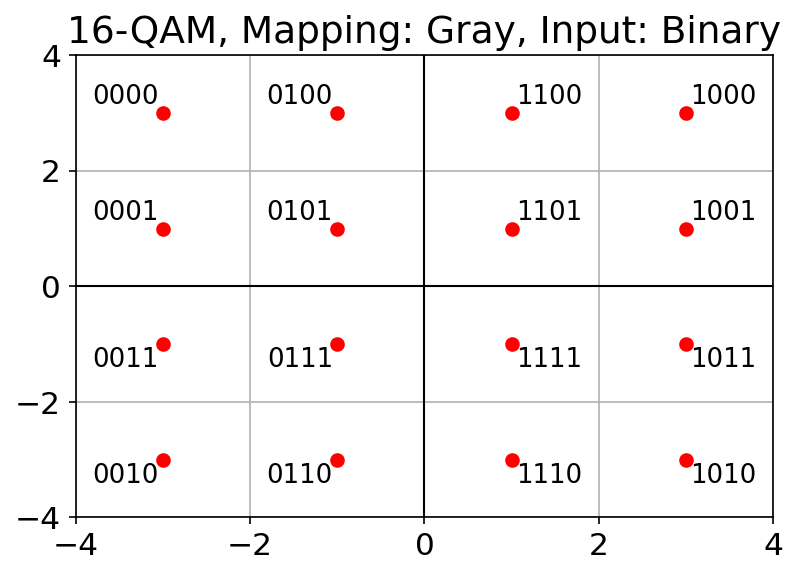

In [104]:
N_constellation_points = 16 # 16QAM modulation

# How many bits we can send using defined number of constellation points
N_bits_per_conts_point = int(np.log2(N_constellation_points))

modem = QAMModem(M = N_constellation_points,
                 bin_input = True,              # it will use bits as input
                 gray_map = True,               # reorder constellation points to have unit distance between neigbours
                 soft_decision = False,         # hard detector for detection
                 bin_output = True)             # demodulate signal to bits
modem.plot_const()

In [129]:
# For each subcarrier transform N_bits_per_conts_point bits into one QAM symbol
bit_streams = 2 # added a number of bit streams
bits = np.random.binomial(n = 1, p = 0.5, size = (bit_streams , N_subcarriers, N_bits_per_conts_point))
print(bits, bits.shape)
# Normalization constant. Dont forget to denormalize signal before decoding!
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

#bitstr_num = 2 # added bit streams number myself
# Create 1 OFDM symbol with N_subcarriers QAM symbols.
# qam_symbols = modem.modulate(bits.flatten()).reshape(N_subcarriers) / constellation_norm
qam_symbols = modem.modulate(bits.flatten()).reshape(bit_streams, N_subcarriers) / constellation_norm

# Print some symbols and check the normalization
print('S size: ',qam_symbols.shape, end = '\n\n')
print('Some symbols : ',qam_symbols[:15], end = '\n\n')
print('Expectation is', np.mean(np.abs(qam_symbols)**2))

[[[0 1 0 1]
  [0 0 0 1]
  [1 1 1 1]
  ...
  [1 1 0 1]
  [1 1 0 1]
  [0 0 0 1]]

 [[0 0 0 0]
  [1 1 0 1]
  [1 1 1 0]
  ...
  [1 0 1 0]
  [1 0 1 1]
  [0 0 1 1]]] (2, 256, 4)
S size:  (2, 256)

Some symbols :  [[-0.31622777+0.31622777j -0.9486833 +0.31622777j  0.31622777-0.31622777j
  -0.31622777+0.31622777j -0.31622777-0.31622777j  0.31622777+0.9486833j
  -0.9486833 -0.9486833j  -0.9486833 +0.31622777j  0.31622777+0.9486833j
   0.31622777+0.31622777j  0.31622777-0.31622777j  0.9486833 +0.9486833j
  -0.9486833 +0.31622777j  0.31622777+0.31622777j  0.9486833 +0.31622777j
   0.31622777+0.31622777j -0.31622777+0.31622777j  0.31622777-0.31622777j
   0.9486833 -0.31622777j -0.31622777+0.9486833j   0.31622777-0.9486833j
  -0.9486833 -0.31622777j  0.9486833 -0.31622777j  0.9486833 -0.9486833j
  -0.9486833 +0.31622777j -0.9486833 -0.31622777j  0.9486833 +0.31622777j
   0.31622777+0.9486833j  -0.9486833 +0.31622777j -0.9486833 +0.31622777j
   0.9486833 +0.9486833j  -0.9486833 -0.31622777j -0.31622

In [193]:
def get_precoder(H, rank, precoder_type = 'uniform'):
	'''
	Calculates precoder with given parameters
	Inputs:
		- H (np.ndarray) is channel matrix with shape of [N_ue_ants x N_bs_ants x N_subcarriers]
		- rank (int) is number of bit-stereams which we want to precode
		- precoder_type (str) : flag, which precoder type to use
		  if precoder_type='uniform' precoder is normalized unit vector (baseline)
		  if precoder_Type='svd' uses Vh singular vectors as precoder (SHOULD BE IMPLEMENTED)
	Returns:
		- precoder (np.ndarray) with shape of [N_bs_ants x rank x N_subcarriers]
	'''

	N_ue, N_bs, N_f = H.shape

	precoder = np.zeros((N_bs, rank, N_f), dtype = np.complex128)

	# here we calculate SVD precoder. Your task to implement it
	if precoder_type == 'svd':
		# ---------------------------------------------------------------------------------------
		U, Sigma, V_t = np.linalg.svd(np.transpose(H, (2, 0, 1)))
		precoder = V_t[...,:rank, :]
		precoder = np.conj(np.transpose(precoder, (2, 1, 0))) # the vectors are in rows
		
		#for subc in range(N_f):
		#	left, singul, right = np.linalg.svd(H[:, :, subc])
		#	right_transposed = np.transpose(right)
		#	right_processed = np.conj(right_transposed)
		#	ness_vectors = right_processed[:, 0 : rank]
		#	precoder[:, :, subc] = ness_vectors
			#for j in range(rank):
			#	for BS in range(N_bs):
			#		precoder[BS, j, subc] = ness_vectors[BS, j]
		#print(ness_vectors.shape, precoder[:, :, 0].shape, right_processed.shape)
		# ---------------------------------------------------------------------------------------
	# here we calculate uniform precoder
	elif precoder_type == 'uniform':
		assert rank == 1  # impossible to use other ranks

		# for each subcarrier
		for subc in range(N_f):
			# precoder norm must be 1
			precoder[..., subc] = np.ones((N_bs, rank)) / (np.sqrt(N_bs * rank));

	
	return precoder


In [161]:
# Precoder testing

# Fix channel for some time moment
t = 0
Ht = H[..., t]

# Calculate precoder
precoder = get_precoder(H = Ht, rank = bit_streams, precoder_type = 'svd')

print('precoder shape: ', precoder.shape)
print('precoder power per subcarrier: ', np.sum(np.abs(precoder)**2)/N_subcarriers)

precoder shape:  (64, 2, 256)
precoder power per subcarrier:  2.0


In [198]:
def transmitter_signal(s_signal, precoder):
	'''
	Forms transmitter signal using modulated data and precoder
	Inputs:
		- s_signal: (np.ndarray) streams of modulated symbols with shape of [rank x N_subcarriers] (added [rank x 1 x N_subcarriers])
		- precoder: (np.ndarray) precoder with shape of [N_bs_ants x rank x N_subcarrires]
	Output:
		- X: (np.ndarray) transmitted precoded signal with shape of [N_bs_ants x N_subcarriers]
	'''
	#if len(s_signal.shape) < 3:
	#	ss = np.expand_dims(s_signal, 1)
	N_bs, rank, N_f = precoder.shape
	if len(s_signal.shape) < 3:
		s_signal = np.expand_dims(s_signal, 1)
	X = np.zeros((N_bs, N_f), dtype = np.complex128)
	X = np.expand_dims(X, axis = 1)
	#print(X.shape)

# calculate independently for each subcarrier
# ---------------------------------------------------------------------------------------
	X = np.einsum('PAN,ABN ->PBN', precoder, s_signal)
	X = np.squeeze(X, 1)	
	#for subc in range(N_f):
	#	X[:, :, subc] = precoder[:,:,subc].dot(ss[:, :, subc])
# ---------------------------------------------------------------------------------------
	#X = np.squeeze(X, axis = 1)
	#print(precoder[:,:,0].shape, ss[:, :, 0].shape, X.shape)
	return X

In [187]:
# print information about TX signal
# X = transmitter_signal(s_signal = qam_symbols[None,:], precoder = precoder)
test_bit_streams = 1
test_qam_symbols = modem.modulate(bits.flatten()).reshape(test_bit_streams, N_subcarriers) / constellation_norm
X = transmitter_signal(s_signal = test_qam_symbols, precoder = precoder)
print('TX signal shape:', X.shape)
print('TX signal power: ', np.sum(np.abs(X)**2))

TX signal shape: (64, 256)
TX signal power:  260.79999999999995


In [164]:
def receiver_signal(H, X, SNR_dB):
	'''
	Model signal at the receiver side. Returns received signal with noise is SNR_dB is int.
	If SNR_dB is None - returns ideal signal
	INPUTS:
		- H (np.ndarray): channel tensor with shape of [N_ue_ants x N_bs_ants x N_subcarrier]
		- X (np.ndarray): transmitted signal matrix with shape of [N_bs_ants x N_subcarrier]
		- SNR_dB (int or None): Signal to Noise ratio in decibels.

	'''
	N_ue, N_bs, N_f = H.shape

	y = np.zeros((N_ue, N_f), dtype = np.complex128)

	# ---------------------------------------------------------------------------------------
	for subc in range(N_f):
		y[:, subc] = H[:, :, subc].dot(X[:, subc])
	# ---------------------------------------------------------------------------------------

	N = get_noise(np.mean(H, 1) * sqrt(N_bs), SNR_dB)
	return y + N

In [165]:
# Check received signal and SNR
# define SNR value
SNR = -10

# Obtain ideal signal without noise
Y_ideal = receiver_signal(Ht, X, None)

# Obtain signal with noise
Y_noisy = receiver_signal(Ht, X, SNR)

# Get noise tensor
Noise = Y_noisy - Y_ideal

# Calcualte mean ideal signal Power
Signal_power_dB = 10 * np.log10( np.mean( np.abs(Y_ideal)**2 ))

# Calculate mean noise Power
Noise_power_dB = 10 * np.log10( np.mean( np.abs(Noise)**2 ))

# Check SNR value
print('SNR: ', Signal_power_dB - Noise_power_dB, 'dB')

SNR:  3.238609181704632 dB


In [166]:
def effective_channel(H, P):
	'''
	Calculates effective channel with shape of [N_ue_ants x rank x N_subcarriers].
	INPUTS:
		- H: channel matrix with shape of [N_ue_ants x N_bs_ants x N_subcarriers]
		- P: channel precoders with shape of [N_bs_ants x rank x N_subcarriers]
	'''

	N_ue, N_bs, N_f = H.shape
	rank = P.shape[1]

	H_eff = np.zeros((N_ue, rank, N_f), dtype = np.complex128)

	# ---------------------------------------------------------------------------------------
	for subc in range(N_f):
		H_eff[:, :, subc] = H[:, :, subc].dot(P[:, :, subc])
	# ---------------------------------------------------------------------------------------

	return H_eff

In [167]:
H_eff_est = effective_channel(Ht, precoder)
print(H_eff_est.shape)

(4, 2, 256)


In [168]:
def equalize(Y, H_Est):
	'''
	Recovers signal that was transmitted using received signal and estimated channel.
	Output has shape of [rank x N_subcarriers]
	INPUTS:
		- Y: received signal with chape of [N_ue_ants x N_subcarriers]
		- H_est: estimated effective channel with shape of [N_ue_ants x rank x N_subcarrires]
	'''
	# Y in [N_ue x N_f]
	# H_est [N_ue x rank x N_f]

	N_ue, N_rank, N_f = H_Est.shape

	s_est = np.zeros((N_rank, N_f), dtype = np.complex128)

	for f in range(N_f):
		W_equalizer = np.linalg.pinv(H_Est[:,:,f])
		s_est[:,f] = W_equalizer @ Y[:,f]

	return s_est

In [169]:
# estimated signal with noise
S_est = equalize(Y_noisy, H_eff_est)

# estimated signal with ideal channel
S_est_ideal = equalize(Y_ideal, H_eff_est)

# print sizes
print(S_est.shape)

(2, 256)


In [170]:
# estimated bit sequence observed with noise
est_bits  = modem.demodulate(S_est.flatten() * constellation_norm)

# estimated bit sequence observed without noise
est_bits_ideal = modem.demodulate(S_est_ideal.flatten() * constellation_norm)

# checking bit-error-rate for noisy channel
print('BER (noisy channel): ', bit_error_rate(bits.reshape(1,-1), est_bits))

# checking bit-error-rate for ideal channel (Must be 0)
print('BER (ideal channel): ', bit_error_rate(bits.reshape(1,-1), est_bits_ideal))

BER (noisy channel):  [0.17724609]
BER (ideal channel):  [0.]


In [171]:
H = normalize(H)


In [203]:
# SNR values we would like to use in modeling
snr_range = np.linspace(-15, 7, 20)

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape
#print(H.shape)
# How many bit streams we have
N_layers = 1

# Select modulation parameters
N_constellation_points = 16
N_bits_per_conts_point = int(np.log2(N_constellation_points))

modem = QAMModem(M = N_constellation_points,
				 bin_input = True,
				 gray_map = True,
				 soft_decision = False,
				 bin_output = True)
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

# allocate memory for ber curves
bers = np.zeros((N_layers, len(snr_range)))

# for each snr value
for snr_idx, snr in enumerate(tqdm(snr_range)):
	# ---------------------------------------------------------------------------------------
	for time in range(N_tti):
		Ht = H[..., time]
		bits = np.random.binomial(n = 1, p = 0.5, size = (N_subcarriers, N_bits_per_conts_point))
		qam_symbols = modem.modulate(bits.flatten()).reshape(N_subcarriers) / constellation_norm
	
		precoder = get_precoder(H = Ht, rank = N_layers, precoder_type = 'uniform')
		X = transmitter_signal(s_signal = qam_symbols[None,:], precoder = precoder)
		Y_noisy = receiver_signal(Ht, X, snr)
		H_eff_est = effective_channel(Ht, precoder)
		S_est = equalize(Y_noisy, H_eff_est)
		est_bits  = modem.demodulate(S_est.flatten() * constellation_norm)
		bers[:, snr_idx] +=  bit_error_rate(bits.reshape(1,-1), est_bits)
	
bers = bers/N_tti
	# ---------------------------------------------------------------------------------------

  0%|          | 0/20 [00:00<?, ?it/s]

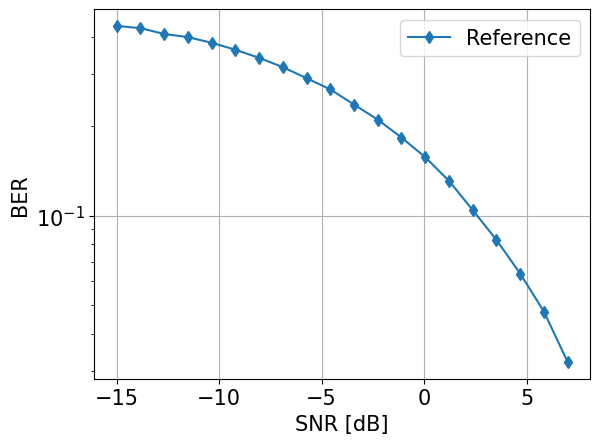

In [204]:
plt.figure()
plt.plot(snr_range, bers[0], 'd-', label = 'Reference')

plt.yscale('log')
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.legend()
plt.show()

In [200]:
# SVD simulations. Single stream
# ---------------------------------------------------------------------------------------
# SNR values we would like to use in modeling
snr_range = np.linspace(-15, 7, 20)

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape
print(H.shape)
# How many bit streams we have
N_layers = 1

# Select modulation parameters
N_constellation_points = 16
N_bits_per_conts_point = int(np.log2(N_constellation_points))

modem = QAMModem(M = N_constellation_points,
				 bin_input = True,
				 gray_map = True,
				 soft_decision = False,
				 bin_output = True)
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

# allocate memory for ber curves
svd_bers = np.zeros((N_layers, len(snr_range)))

# for each snr value
for snr_idx, snr in enumerate(tqdm(snr_range)):
	# ---------------------------------------------------------------------------------------
	for time in range(N_tti):
		Ht = H[..., time]
		bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers, N_subcarriers, N_bits_per_conts_point))
		qam_symbols = modem.modulate(bits.flatten()).reshape(N_layers, N_subcarriers) / constellation_norm
	
		precoder = get_precoder(H = Ht, rank = N_layers, precoder_type = 'svd')
		X = transmitter_signal(s_signal = qam_symbols, precoder = precoder)
		Y_noisy = receiver_signal(Ht, X, snr)
		H_eff_est = effective_channel(Ht, precoder)
		S_est = equalize(Y_noisy, H_eff_est)
		est_bits  = modem.demodulate(S_est.flatten() * constellation_norm)
		svd_bers[:, snr_idx] +=  bit_error_rate(bits.reshape(1,-1), est_bits)
	
svd_bers = svd_bers/N_tti
# ---------------------------------------------------------------------------------------

(4, 64, 256, 100)


  0%|          | 0/20 [00:00<?, ?it/s]

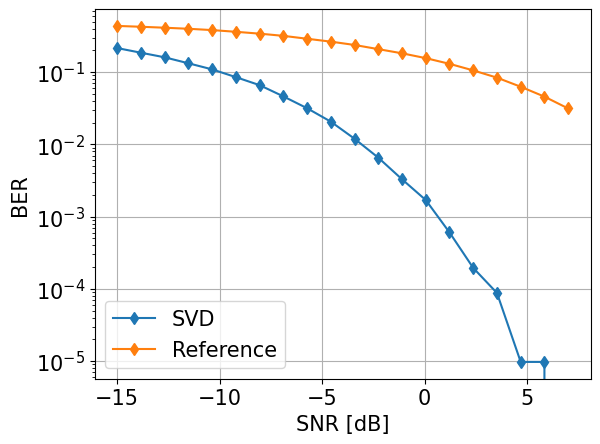

In [201]:
plt.figure()
plt.plot(snr_range, svd_bers[0], 'd-', label = 'SVD')
plt.plot(snr_range, bers[0], 'd-', label = 'Reference')
plt.yscale('log')
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.legend()
plt.show()

In [209]:
# SVD simulations. Double stream. 50/50 energy spliting
# ---------------------------------------------------------------------------------------
# SNR values we would like to use in modeling
snr_range = np.linspace(-15, 7, 20)

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape
print(H.shape)
# How many bit streams we have
N_layers = 2

# Select modulation parameters
N_constellation_points = 16
N_bits_per_conts_point = int(np.log2(N_constellation_points))

modem = QAMModem(M = N_constellation_points,
				 bin_input = True,
				 gray_map = True,
				 soft_decision = False,
				 bin_output = True)
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

# allocate memory for ber curves
svd_bers_2 = np.zeros((N_layers, len(snr_range)))
print(svd_bers_2.shape)

# for each snr value
for snr_idx, snr in enumerate(tqdm(snr_range)):
	# ---------------------------------------------------------------------------------------
	for time in range(1):
		Ht = H[..., time]
		bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers ,N_subcarriers, N_bits_per_conts_point))
		qam_symbols = modem.modulate(bits.flatten()).reshape(N_layers, N_subcarriers) / constellation_norm
	
		precoder = get_precoder(H = Ht, rank = N_layers, precoder_type = 'svd')
		precoder /= sqrt(N_layers)
		
		X = transmitter_signal(s_signal = qam_symbols, precoder = precoder)
		Y_noisy = receiver_signal(Ht, X, snr)
		H_eff_est = effective_channel(Ht, precoder)
		S_est = equalize(Y_noisy, H_eff_est)
		est_bits  = modem.demodulate(S_est.flatten() * constellation_norm)
		
		svd_bers_2[..., snr_idx] +=  bit_error_rate(bits.reshape(1,-1), est_bits)
		print(precoder.shape, Y_noisy.shape, H_eff_est.shape, S_est.shape, est_bits.shape, bit_error_rate(bits.reshape(1,-1), est_bits).shape)
	
svd_bers_2 /= N_tti
# ---------------------------------------------------------------------------------------

(4, 64, 256, 100)
(2, 20)


  0%|          | 0/20 [00:00<?, ?it/s]

(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048,) (1,)
(64, 2, 256) (4, 256) (4, 2, 256) (2, 256) (2048

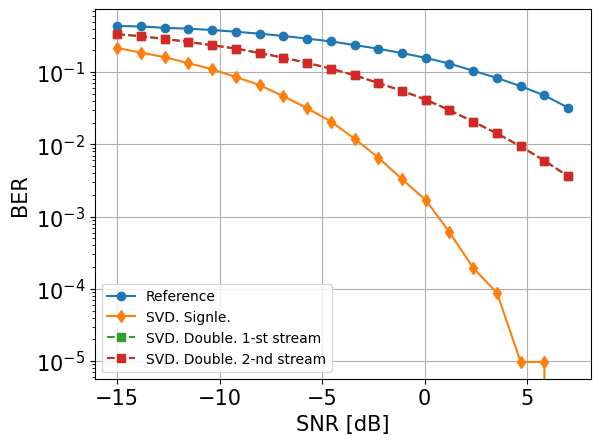

In [206]:
# plot results
plt.figure()
plt.plot(snr_range, bers[0], 'o-', label = 'Reference')
plt.plot(snr_range, svd_bers[0], 'd-', label = 'SVD. Signle.')
plt.plot(snr_range, svd_bers_2[0], 's--', label = 'SVD. Double. 1-st stream')
plt.plot(snr_range, svd_bers_2[1], 's--', label = 'SVD. Double. 2-nd stream')

plt.yscale('log')
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.legend(fontsize = 10)
plt.show()